In [ ]:
# notebooks/hard_mining_analysis.ipynb

#  necessary libraries
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [2]:
print(os.getcwd())
os.chdir('c:/Users/uparp/Desktop/ezy/part12')

c:\Users\uparp\Desktop\ezy\part12\techtrack\notebooks


In [ ]:

#  hard negative mining functions
from techtrack.rectification.hard_negative_mining import compute_loss, sample_hard_negatives, compute_entropy
from techtrack.inference.object_detection import Model


In [ ]:

#  logistics directory 
logistics_dir = "logistics"
prediction_dir = 'output'  

#  prediction directory exists
os.makedirs(prediction_dir, exist_ok=True)

# Load the pre-trained model
config_path = '.\yolo_model_2\yolov4-tiny-logistics_size_416_2.cfg'
weights_path = '.\yolo_model_2\yolov4-tiny-logistics_size_416_2.weights'
class_names_path = '.\yolo_model_2\logistics.names'
model = Model(config_path, weights_path, class_names_path)


In [ ]:

# Function to parse ground truth 
def parse_ground_truth_boxes(file_path):
    """
    Parses ground truth bounding boxes 
    
    Each line in the file is:
    `class_id x_min y_min x_max y_max`
    
    Returns:
    - A list of dictionaries, containing 'bbox' and 'class_id'.
    """
    ground_truth_boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))  # x_min, y_min, x_max, y_max
            ground_truth_boxes.append({'bbox': bbox, 'class_id': class_id})
    return ground_truth_boxes





# function to generate predictions for each image and save to prediction_dir
def generate_predictions(image_dir, prediction_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]  
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        # Run prediction
        model.set_frame_shape(image.shape)
        predict_output = model.predict(image)
        score_threshold = 0.5
        bboxes, class_ids, scores = model.post_process(predict_output, score_threshold)

        #  predictions in the required format, 
        predictions = []
        for bbox, class_id, score in zip(bboxes, class_ids, scores):
            predictions.append({
                'bbox': [int(coord) for coord in bbox],  
                'class_id': int(class_id),               
                'confidence_scores': [float(score)]      
            })

        #  predictions to JSON file
        prediction_file = os.path.join(prediction_dir, f"{image_file.split('.')[0]}.json")
        with open(prediction_file, 'w') as f:
            json.dump(predictions, f)


In [20]:
generate_predictions(logistics_dir, prediction_dir)


In [ ]:
# Load the first 10 prediction files from prediction_dir for analysis
sample_files = [f for f in os.listdir(logistics_dir) if f.endswith(('.jpg', '.png'))][:10]


predictions = [json.load(open(os.path.join(prediction_dir, file.split('.')[0] + '.json'))) for file in sample_files]

# Parse ground truth annotations 
annotations = []
for file in sample_files:
    print(file)
    base_filename = file.replace('.jpg', '')
    
    ground_truth_file = os.path.join(logistics_dir, f"{base_filename}.txt")
    # ground_truth_file = f"logistics\{base_filename}.txt"
    
    #  ground truth bounding boxes
    annotations.append(parse_ground_truth_boxes(ground_truth_file))

# Calculate losses 
losses = []
for prediction, annotation in zip(predictions, annotations):
    loss = compute_loss(prediction, annotation)
    losses.append(loss)

# Output 
print("Losses for each sample:", losses)


-01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.jpg
-01-15-1-4-1-1-14_jpg.rf.2e89a06faa1c217b95a0e0d7177e8397.jpg
-01-15-1-4-1-4-111_jpg.rf.ead3505e4a61d1c97ae2e235b7b228d5.jpg
-01-15-1-4-1-5-45_jpg.rf.0797388e664e12ff935b062e665f32ac.jpg
-01-15-2-2-2-1-212_jpg.rf.c3706c341a4cbb939c5b1341793bc0d8.jpg
-01-15-2-3-2-4-37_jpg.rf.0a2f9cb02817b70c5a56c6082535a7b6.jpg
-01-16-1-1-1-1-20_jpg.rf.27f842b8dd4032c96ad8afc13dc855f8.jpg
-01-16-1-2-1-3-14_jpg.rf.c2febebedae30ca6c5d67ea7adf8973b.jpg
-01-16-2-1-2-4-20_jpg.rf.7de07f4de98267e416ac90e110467400.jpg
-01-16-2-1-2-5-44_jpg.rf.3db2a524f3617f046a2a3b9c48a0c5ee.jpg
Losses for each sample: [14.0, 6.0, 6.0, 12.0, 24.0, 10.0, 16.0, 6.0, 20.0, 10.0]


In [8]:


num_samples = 5
hard_negatives = sample_hard_negatives(prediction_dir, logistics_dir, num_samples=num_samples)
print("Top Hard Negatives:", hard_negatives)


Top Hard Negatives: [('image_from_china-631-_jpg.rf.04ec96c7163e22bc269b6366f4cb930d.jpg', 54.0), ('image_from_china-631-_jpg.rf.04ec96c7163e22bc269b6366f4cb930d.txt', 54.0), ('1564562592-9600837_jpg.rf.6d06807332558a5945927e4595cc0a89.jpg', 50.0), ('1564562592-9600837_jpg.rf.6d06807332558a5945927e4595cc0a89.txt', 50.0), ('1564562613-2884808_jpg.rf.0e55b8cdc9c4f6f9cca6ebdab380e165.jpg', 42.0)]


logistics\image_from_china-631-_jpg.rf.04ec96c7163e22bc269b6366f4cb930d.jpg


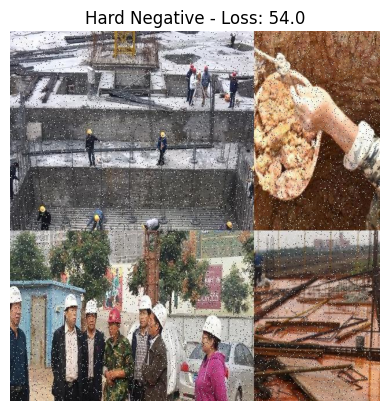

logistics\1564562592-9600837_jpg.rf.6d06807332558a5945927e4595cc0a89.jpg


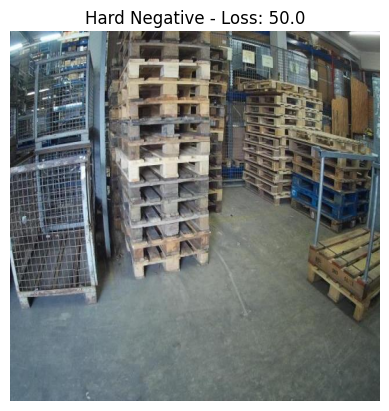

logistics\1564562613-2884808_jpg.rf.0e55b8cdc9c4f6f9cca6ebdab380e165.jpg


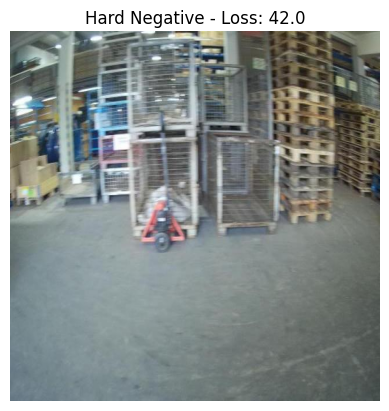

In [ ]:

# Visualize 

for file_name, loss in hard_negatives:
    if file_name.endswith('.txt'):
        continue
    img_path = os.path.join(logistics_dir, file_name)
    
    print(img_path)
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Hard Negative - Loss: {loss}")
    plt.axis('off')
    plt.show()




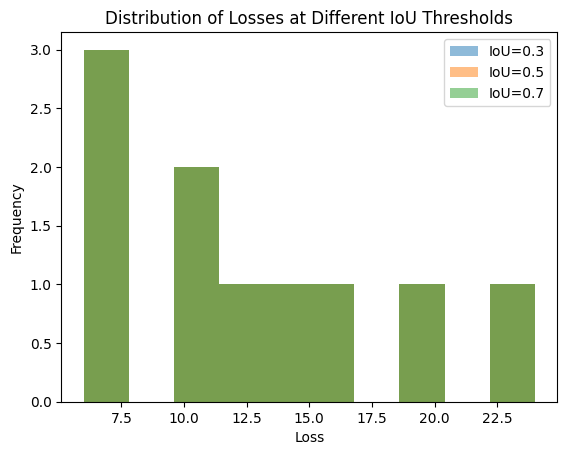

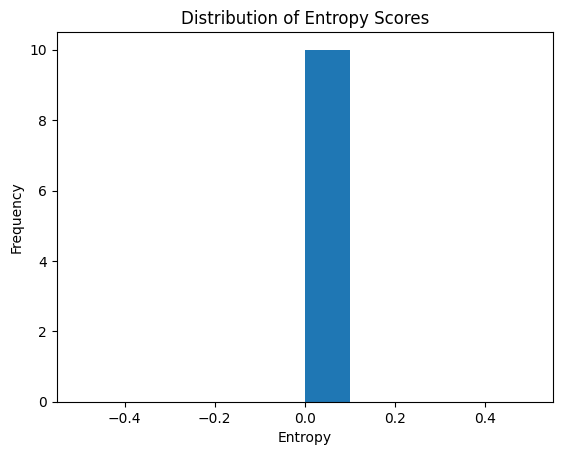

Summary:
- Which samples were consistently identified as hard negatives?
- How do different IoU thresholds affect the selection of hard samples?
- How does model uncertainty (high entropy) correlate with hard samples?


In [ ]:

# Experiment w different IoU thresholds
iou_thresholds = [0.3, 0.5, 0.7]
for threshold in iou_thresholds:
    modified_losses = []
    for prediction, annotation in zip(predictions, annotations):
        loss = compute_loss(prediction, annotation)
        modified_losses.append(loss)
    
    plt.hist(modified_losses, bins=10, alpha=0.5, label=f'IoU={threshold}')
plt.title("Distribution of Losses at Different IoU Thresholds")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#  model uncertainty using entropy
entropy_scores = [compute_entropy(pred) for pred in predictions]
plt.hist(entropy_scores, bins=10)
plt.title("Distribution of Entropy Scores")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

print("Summary:")
print("- Which samples were consistently identified as hard negatives?")
print("- How do different IoU thresholds affect the selection of hard samples?")
print("- How does model uncertainty (high entropy) correlate with hard samples?")
